# Overview

This document covers the transformation of ICESat-2 photon data over a target reef to depth estimates that will be used to calibrate Sentinel-2 bathymetry estimates.  The relevant program files are located in the <i><b>/src</i></b> directory in Karan Sunil's "Coral-Reef-Bathymetry" distribution on GitHub: https://github.com/karans04/Coral-Reef-Bathymetry

## 1.) Import packages

To begin, make sure this notebook is located and launched from a working directory containing <i><b>Depth_profile.py</i></b> and the other python files in Karan's distribution. After the imports below, any function available in <i><b>Depth_profile.py</i></b> can be called from this notebook with the syntax: depth.function_name(parameters). The same goes for the other imported python files.

Note: sentinelsat is a package external to Anaconda3.  Downloaded the package from ESA, unzip, cd into it, then install into the base environment using /opt/anaconda3/bin/pip3 install sentinelsat or into a virtual environment using /opt/anaconda3/envs/[env name]/bin/pip3 install sentinelsat.

Also, to get Beautiful Soup to work, I had to install the lxml library from the command line: conda install --name rasteriok lxml

In [1]:
import geopandas as gpd
import h5py
import importlib
import json
import lxml
import math
import matplotlib
import numpy as np
import os
import pandas as pd
import pyproj as proj
import rasterio
import requests
import seaborn as sns
import sys
import zipfile
import getpass

from bs4 import BeautifulSoup
from datetime import datetime
from pathlib import Path
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sklearn.cluster import DBSCAN

import ATL03_API as is2api
import Coral_Reef as coral_reef
import Depth_profile as depth
import ICESAT_plots as is2_plot
import IS2_file as is2File
import Pixel_transformation as pt
import Reef_plots as reef_plots
import Sentinel_API as sentinel
import Sentinel2_image as s2_img
import Tide_API as tide
import Water_level as water_level

## 2.) Create directories and files needed for depth processing

In working directory, create a folder called <i><b>data</i></b> and create subfolders for each reef being analyzed.  Within each subfolder, provide the following folders/files:

<blockquote><b>A.)</b> a GeoJSON file containing the outline of the reef, named <i><b>reef_name.geojson</i></b>.  This file is obtained from http://geojson.io/#map=2/20.0/0.0.  Switch to "OSM model" in bottom left corner of window, mark the boundary of reef with the cursor, save points using the menu at upper left (save->GeoJSON), then rename map.geojson file and move to data directory.
<p>
<b>B.)</b> a folder named <i><b>H5</i></b> which contains ICESat-2 ATL03 data files for this reef.  These are HDF5 files that can be obtained from OpenAltimetry (http://www.openaltimetry.org) or from NASA EarthData search (https://search.earthdata.nasa.gov/search/granules?p=C1705401930-NSIDC_ECS)
<p>
<b>C.)</b> a file called <i><b>reef_name.text</i></b> containing metadata.  The format must be:<br>
<blockquote>Coordinates: <p>
[min_lat, max_lat, min_lon, max_lon] <br><br>H5 Files:<br>List of all h5 files in folder H5, one file per line.</blockquote></blockquote>

## 3.) Input metadata for reef processing

[run.py] <br>
Setting reef processing parameters can be done programatically via Karan's top-level processing script <i><b>run.py</i></b>, which updates <i><b>config/data-params.json</i></b>. Here these parameters are set via the command line.

In [2]:
reef_name = 'molokai'
data_dir = '/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/'
start_date = '20181101'
end_date = '20200601'
redownload_is2 = False  #False = use the data already downloaded into the directory
earthdata_username = 'bludka'
earthdata_password = ''
sentinel_username = 'aborsa_sentinel'#'bludka';#'aborsa_sentinel'
sentinel_password = 'Esa0169!'#'Gnidlaps10!'#getpass.getpass('Earthdata Login password: ')#'Esa0169!'
world_tide_API_key = 'fee8ff39-48eb-42a7-bcc5-3819fce3c1e4'

## 4.) Initialize Coral_Reef( ) data object

[run.py] <br>
Create a Coral_Reef object to hold metadata for each reef. Take a look in Coral_Reef.py for the methods and variables defined for the Coral_Reef class. Also note that the get_bounding_box( ) method queries <i><b>/data/reef_name/reef_name.txt</i></b> to grab the reef bounding box coordinates.

In [4]:
reef = coral_reef.Coral_Reef(data_dir, reef_name)
icesat_fp, proc_fp, images_fp, data_plots_path = reef.get_file_drectories()


## 5.) Get ICESat-2 data for reef

[run.py] <br>
This requires running <i><b>/src/IS2_file.main()</i></b>, which we are not going to do for this example.

## 6.) Estimate photon depths

[run.py / Depth_profile.py / get_depths(reef) / process_H5()]<br>
Assuming for now that the ICESat-2 data have been downloaded and dropped into the <i><b>H5</i></b> directory, we will work with the <i><b>first</i></b> file for the example below.
The depth.process_H5(reef) method will run the entire depth estimation workflow. Here it is line-by-line:

In [5]:
#Get IS2 file directory and filenames
h5_dir = os.path.join(reef.get_path(),'H5')
h5_filenames = [f for f in os.listdir(h5_dir) if not f.startswith('.')]
h5_filenames.sort()
print (h5_filenames)
print('hello')
print(h5_filenames[0])

#reloads stuff in case you are editing the .py files at the same time
importlib.reload(depth)
importlib.reload(is2File)
importlib.reload(water_level)

['processed_ATL03_20190111094917_02130207_003_01.h5']
hello
processed_ATL03_20190111094917_02130207_003_01.h5


<module 'Water_level' from '/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/Water_level.py'>

<class 'list'>
['processed_ATL03_20190111094917_02130207_003_01.h5']

processed_ATL03_20190111094917_02130207_003_01.h5
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/molokai/Output/Data_Cleaning/ICESAT_photons/molokai_photons_processed_ATL03_20190111094917_02130207_003_01_gt1l.csv
          Height   Latitude   Longitude  Conf_land  Conf_ocean  \
0      17.201893  21.109317 -157.097185        4.0         4.0   
1      18.566885  21.109318 -157.097185        4.0         4.0   
2      17.950193  21.109318 -157.097185        4.0         4.0   
3      17.191101  21.109311 -157.097185        4.0         4.0   
4      17.840261  21.109311 -157.097185        4.0         4.0   
...          ...        ...         ...        ...         ...   
14390  16.838327  21.073615 -157.098653        4.0         4.0   
14391  16.734085  21.073615 -157.098653        4.0         4.0   
14392  16.892004  21.073608 -157.098653        4.0         4.0   
14393  16.618357  21.073602 -157.098654        

/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferre

Number depth photons in gt1l is 2502
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/molokai/Output/Data_Cleaning/ICESAT_photons/molokai_photons_processed_ATL03_20190111094917_02130207_003_01_gt2l.csv
          Height   Latitude   Longitude  Conf_land  Conf_ocean  \
0     159.190735  21.109252 -157.128032        4.0         4.0   
1     160.848267  21.109254 -157.128032        4.0         4.0   
2     613.952026  21.109618 -157.127917        0.0         0.0   
3     160.792908  21.109221 -157.128033        4.0         4.0   
4     157.839569  21.109218 -157.128034        4.0         4.0   
...          ...        ...         ...        ...         ...   
9297   16.760288  21.073570 -157.129529        4.0         4.0   
9298   16.566423  21.073563 -157.129530        4.0         4.0   
9299   16.841072  21.073563 -157.129530        4.0         4.0   
9300   16.507439  21.073563 -157.129530        4.0         4.0   
9301   16.953106  21.073563 -157.129530        4.0         4.0  

/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferre

/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/molokai/Output/Data_Cleaning/ICESAT_photons/molokai_photons_processed_ATL03_20190111094917_02130207_003_01_gt3l.csv
           Height   Latitude   Longitude  Conf_land  Conf_ocean  \
0      190.911896  21.109367 -157.158899        4.0         4.0   
1      192.609833  21.109369 -157.158899        4.0         4.0   
2      189.654175  21.109353 -157.158900        4.0         4.0   
3      188.078949  21.109352 -157.158901        4.0         4.0   
4      186.055374  21.109344 -157.158902        4.0         4.0   
...           ...        ...         ...        ...         ...   
10316   17.010778  21.073672 -157.160409        4.0         4.0   
10317   17.065821  21.073672 -157.160409        4.0         4.0   
10318   16.928871  21.073672 -157.160409        4.0         4.0   
10319   17.095324  21.073672 -157.160409        4.0         4.0   
10320   16.555721  21.073665 -157.160409        4.0         4.0   

       Conf_inlandwate

/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferre

Number depth photons in gt3l is 884


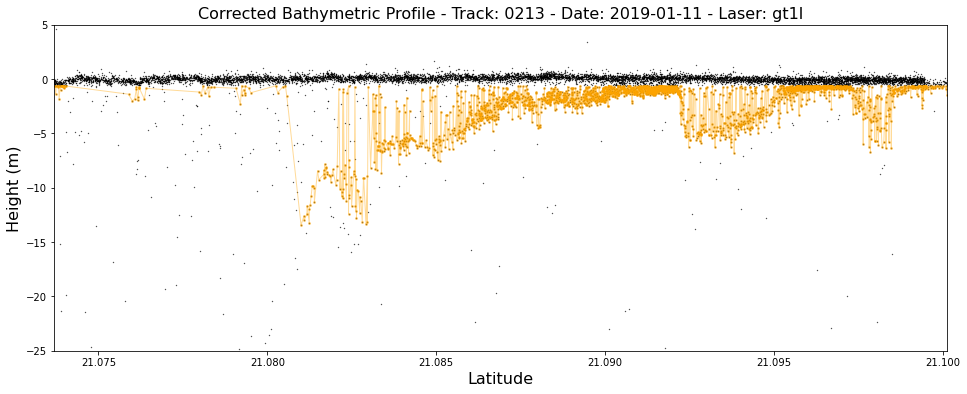

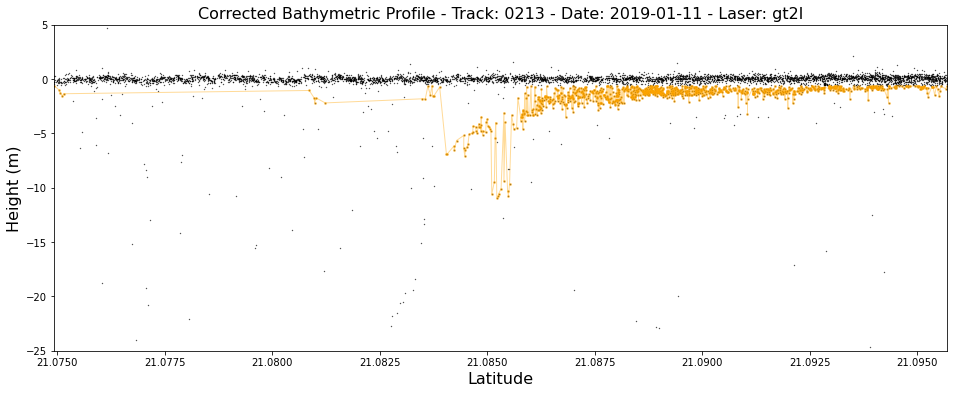

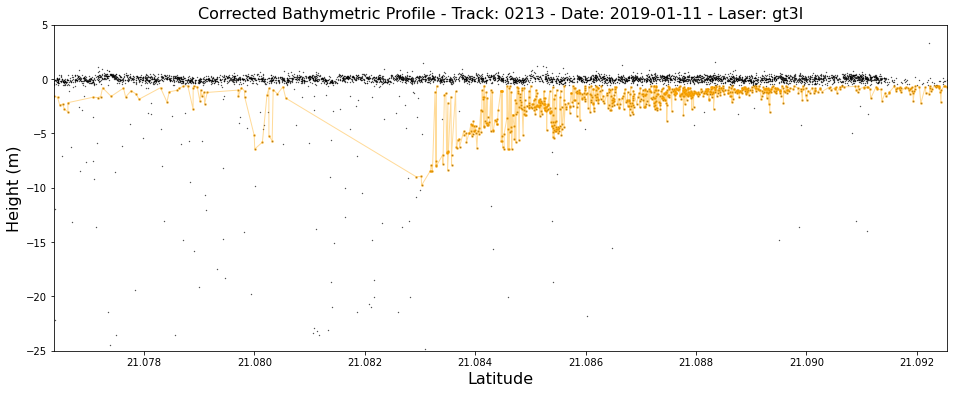

In [6]:
print(type(h5_filenames))
#h5_filenames = h5_filenames[0]
print(h5_filenames)
for h5_fn in h5_filenames:
    print('\n' + h5_fn)

    #Inititalize ICESat-2 file object 
    is2 = is2File.IS2_file(h5_dir, h5_fn, reef.bbox_coords)
    is2_file_tag = is2.get_file_tag()

    strong_beams = is2.get_strong_lasers() #figure out which beams you want based on sat orientation
    for laser in strong_beams:

        #Output directory for csv file containing raw photon data
        photon_fn = '{reef_name}_photons_{h5_fn}_{laser}.csv'.format(reef_name=reef_name, h5_fn=is2_file_tag, laser=laser)
        photons_path = os.path.join(icesat_fp, photon_fn)
        print(photons_path)
        #Load raw photon data if it already exists, else extract it from h5 file
        #if not os.path.exists(photons_path):
        
        
        ######------- indent here
        #From process_h5(): df = convert_h5_to_csv(is2_file, laser, photons_path)

        #Create dataframe with photon data
        photon_data = is2.get_photon_data(laser)  
        if len(photon_data) == 0:
            print('No photons in file for {}'.format(laser))
            continue            
        df_laser = depth.create_photon_df(photon_data) #creates dataframe (table-like thing of photon data)
        print(df_laser)
        #Clip dataframe to locations within the reef bounding box
        coords = is2.get_bbox_coordinates()
        min_longitude,min_latitude,max_longitude,max_latitude = coords
        df = df_laser.loc[(df_laser.Longitude > min_longitude) & (df_laser.Longitude < max_longitude) &\
        (df_laser.Latitude > min_latitude) & (df_laser.Latitude < max_latitude)]

        #If there are photons in the new clipped dataframe
        if len(df) != 0:    

            #Unpack the confidence array to individual columns (now done in get_photon_data
            #df = depth.individual_confidence(df)
            #surface_photons = depth.apply_DBSCAN(df, processed_output_path,is2, laser, eps_val, min_samp)
            f = water_level.get_water_level(df)
            #is2_plot.plot_is2_depths(df, is2, laser, f, [0, 55], 'Raw Photon Elevs')

            #Adjust elevations to reference local sea level (currently this step ALSO subsets on confidence==4)
            #Unlike Karan's code, df now contains 'sea_level', which is what has been removed from 'Heights'
            df,f = water_level.normalise_sea_level(df)
            if len(df) == 0:  
                print('Failed at sea level parameterization for {}'.format(laser))
                continue
            is2.set_sea_level_function(f,laser) #store sea level function in metadata

            #Adjust depth for speed of light in water
            df = water_level.adjust_for_speed_of_light_in_water(df)
            #is2_plot.plot_is2_depths(df, is2, laser, 'False', [-25, 5], 'Adjusted Photon Elevs')

            #Write a dataframe containing just the photon data in bounding box that meet the confidence criterion
            print('Writing photons for clipped dataframe to csv file for {}'.format(laser))
            df.to_csv(photons_path)

        else:
            print('No photons over reef for {}'.format(laser))
            ######------- end indent here
        #else:
        #    print('Reading photons from prior csv file for {}'.format(laser))
        #    df = pd.read_csv(photons_path)
        

        is2.metadata = is2.load_json()       

        #Calculate depths
        print('Number photons in {laser} is {reef_length}'.format(laser=laser, reef_length=str(len(df))))

        eps_val = 1 # horizontal distance over which you are looking for a core sample of photons - choose carefully
        min_samp = 5 #minimum number of photons to be considered a core sample - make bigger to reduce noise
        bathy, non_bathy = depth.apply_DBSCAN(df, eps_val, min_samp, -50, -0.6) #https://scikit-learn.org/stable/modules/clustering.html#dbscan
        if len(bathy) == 0:
            print('No bathymetric photons found for {}'.format(laser))
            continue
        print('Number depth photons in {laser} is {reef_length}'.format(laser=laser, reef_length=str(len(bathy))))
        depths_fn = '{reef_name}_{h5_fn}_{laser}.csv'.format(reef_name=reef_name,h5_fn=is2_file_tag,laser=laser)
        processed_output_path = os.path.join(proc_fp,depths_fn)
        bathy.to_csv(processed_output_path)
        
        #Plot depths
        is2_plot.plot_is2_depths_bathy(df, is2, laser, bathy, images_fp, 'False', [-25, 5], 'Corrected Bathymetric Profile')

In [7]:
print(df)

           Height   Latitude   Longitude  Conf_land  Conf_ocean  \
25     -49.777843  21.109027 -157.158983        0.0         0.0   
108    -80.215865  21.108653 -157.159011        0.0         0.0   
439   -113.823590  21.107038 -157.159092        0.0         0.0   
978   -257.365043  21.104576 -157.159244        0.0         0.0   
1319  -166.893287  21.103233 -157.159269        0.0         0.0   
...           ...        ...         ...        ...         ...   
10316    0.172085  21.073672 -157.160409        4.0         4.0   
10317    0.213367  21.073672 -157.160409        4.0         4.0   
10318    0.110654  21.073672 -157.160409        4.0         4.0   
10319    0.235494  21.073672 -157.160409        4.0         4.0   
10320   -0.169210  21.073665 -157.160409        4.0         4.0   

       Conf_inlandwater  sea_surface    raw_elev  
25                 -1.0    16.442387  -49.928070  
108                -1.0    16.449360  -90.505127  
439                -1.0    16.478715 -135.

## 7.) Get Sentinel-2 images

This uses code taken from Sentinel_API.py

In [28]:
#importlib.reload(sentinel)
cloud_cover_percentage = [0, 5]

#sentinel.get_sentinel_images(reef, start_date, end_date, 10, sentinel_username, sentinel_password, cloud_cover_percentage)
api = SentinelAPI(sentinel_username, sentinel_password, 'https://scihub.copernicus.eu/dhus')
reef_path = reef.get_path()
reef_gjson_fp = os.path.join(reef_path ,reef.get_reef_name()+'.geojson')
reef_footprint = geojson_to_wkt(read_geojson(reef_gjson_fp))
sentinel_path = os.path.join(reef_path, 'SAFE_files')

products = api.query(reef_footprint,date = (start_date, end_date),platformname = 'Sentinel-2',\
            area_relation = 'Intersects',processinglevel = 'Level-2A',\
            cloudcoverpercentage = cloud_cover_percentage, order_by = 'cloudcoverpercentage')  
print('Number of scenes: {}'.format(len(products)))

for i,x in enumerate(products.items()):
    k,v = x[0],x[1] #what is k?
    safe_folder = os.path.join(sentinel_path, v['title'] + '.SAFE')
    if not os.path.exists(safe_folder):
        print('Downloading: {}'.format(safe_folder))
        api.download(k, directory_path = sentinel_path)
    else:
        print('{} exists!'.format(safe_folder))
        

#unzipping files
for file in os.listdir(sentinel_path):
    if file.endswith('.zip'):
        file_path = os.path.join(sentinel_path, file)
        out_path = os.path.join(sentinel_path, file.split('.')[0])

        if os.path.exists(file_path) and not os.path.exists(out_path):
            with zipfile.ZipFile(file_path,"r") as zip_ref:
                zip_ref.extractall(sentinel_path)
            os.remove(file_path)

Number of scenes: 9
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2B_MSIL2A_20200510T220919_N0214_R129_T01KCV_20200510T235623.SAFE exists!
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2B_MSIL2A_20190605T220929_N0212_R129_T01KCV_20190606T000535.SAFE exists!
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2A_MSIL2A_20190809T220921_N0213_R129_T01KCV_20190809T235948.SAFE exists!
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2B_MSIL2A_20190715T220929_N0213_R129_T01KCV_20190716T001515.SAFE exists!
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2B_MSIL2A_20200121T220909_N0213_R129_T01KCV_20200121T235759.SAFE exists!
/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2A_MSIL2A_20191127T220921_N0213_R129_T01KCV_20191127T234838.SAFE exists!
Downloading: /Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2B_M

Product 2e143651-65e6-46dc-b5ca-f4ec40a44d47 is not online. Triggering retrieval from long term archive.


Downloading: /Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2B_MSIL2A_20190317T220919_N0211_R129_T01KCV_20190317T234931.SAFE


Product 36504654-2e81-44e0-a1af-ac3400ec22ed is not online. Triggering retrieval from long term archive.


/Users/bonnieludka/Spaceship/IceSAT2/run_bathymetry/data/nasau/SAFE_files/S2A_MSIL2A_20191018T220921_N0213_R129_T01KCV_20191018T235259.SAFE exists!


## 8.) Process Sentinel-2 images

This uses code taken from Pixel_transformation.py.
Band 02 = Blue, Band 03 = Green, Band 04 = Red, Band 08 = Infrared.  All are 10 m resolution.

In [43]:
importlib.reload(s2_img)
importlib.reload(pt)
importlib.reload(tide)

datum = {}
medians, variances = [], []
master_df = pd.DataFrame()

median_threshold, variance_threshold = 1, 1

reef_path = reef.get_path()
reef_name = reef.get_reef_name()
safe_files = os.path.join(reef_path, 'SAFE_files')
coords = reef.get_bounding_box()

#for sf in os.listdir(safe_files):
#    if sf.endswith('.SAFE'):
#        #creates object to represent sentinel image
#        sf_path = os.path.join(reef_path, sf)
#        safe_file = s2_img.Sentinel2_image(sf_path,coords)
#        #get out file directories
#        imgs_path, depth_preds_path, training_data_path = safe_file.get_file_directories()
#        #fits the regressor with training data
#        r,m,d = get_regressor(reef,safe_file)

sf = os.listdir(safe_files)
sf = [f for f in sf if f.endswith('.SAFE')]
sf = sf[0]  #just work with first SAFE file for now #############################################################

#creates object to represent sentinel image
sf_path = os.path.join(reef_path, sf)
safe_file = s2_img.Sentinel2_image(sf_path,coords)
#get out file directories
imgs_path, depth_preds_path, training_data_path = safe_file.get_file_directories()

TypeError: reload() argument must be a module

In [30]:
#create a training dataset using ICESAT 2 depth profile
#train = pt.load_ICESAT_predictions(icesat_proc_path, safe_file)
icesat_proc_path = reef.get_processed_output_path()
train_raw = pd.DataFrame()
is2files = [file for file in os.listdir(icesat_proc_path) if file.endswith('.csv')]
for fn in is2files:
    train_path = os.path.join(icesat_proc_path, fn)
    train_raw = pd.concat([train_raw, pt.prep_df(safe_file, train_path, safe_file.get_crs())])  #pt.prep_df where we use Sentinel training data to pick pixels where there is ICESat2 data 

#drop any nan rows
train_raw = train_raw.dropna()
train_raw['x'] = train_raw.Coordinates.x
train_raw['y'] = train_raw.Coordinates.y
#photon_location = sns.scatterplot(x = train_raw['x'], y = train_raw['y'], color = 'black')  

2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: -0.381



/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: -0.381

2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: -0.381

2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: -0.381

2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: -0.381

2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: -0.381

2019-03-11 08:17:11
ICESat-2 tide level: 0.282
Sentinel-2 tide level: -0.381

2019-03-11 08:17:11
ICESat-2 tide level: 0.282
Sentinel-2 tide level: -0.381

2019-03-11 08:17:11
ICESat-2 tide level: 0.282
Sentinel-2 tide level: -0.381

2019-06-10 03:56:47
ICESat-2 tide level: -0.244
Sentinel-2 tide level: -0.381

2019-06-10 03:56:47
ICESat-2 tide level: -0.244
Sentinel-2 tide level: -0.381

2019-06-10 03:56:47
ICESat-2 tide level: -0.244
Sentinel-2 tide level: -0.381

2020-03-08 14:56:11
ICESat-2 tide level: 0.002
Sentinel-2 tide level: -0.381



In [31]:
def get_pixel_val(coord):
    """
    Get pixel value given a set of coordinates
    Params - 1. coord (Point) - point of interest
    Return int - pixel value at point
    """
    x_index = int((coord.x - meta['ulx']) // meta['xdim'])
    y_index = int((coord.y - meta['uly']) // (meta['ydim']))
    return [data[0][y_index][x_index] for data in imgs]

def get_pixel_image_coords(coord):
    """
    Get pixel coordinates
    Params - 1. coord (Point) - point of interest
    Return int - pixel coords
    """
    x_index = int((coord.x - meta['ulx']) // meta['xdim'])
    y_index = int((coord.y - meta['uly']) // (meta['ydim']))
    return y_index, x_index

def extract_pixel_cols(df):
    """
    Extracts band values for image
    Params - 1. df (DataFrame) - depth predictions of ICESAT-2
    Return - DataFrame - pixel values added for each point
    """
    df['Pixels'] = df.Coordinates.apply(get_pixel_val)
    df['b2'] = df.Pixels.apply(lambda x: (x[0]))
    df['b3'] = df.Pixels.apply(lambda x: (x[1]))
    df['b4'] = df.Pixels.apply(lambda x: (x[2]))
    df['b8'] = df.Pixels.apply(lambda x: (x[3]))
    
    #converts points with pixel values above the mask threshold to nan
    #df['mask'] = df.b8.apply(lambda x: False if x < mask_thresh else True)
    
    return df

In [32]:
#fits the regressor with training data
#r,m,d = get_regressor(reef,safe_file)

#load in the different band images required
imgs = safe_file.load_sentinel()
meta = safe_file.get_meta()

### get band values at IS2 pixels
train = train_raw.copy(deep=True)  #first make a copy of "train" so it can be altered for each S2 image
train = extract_pixel_cols(train)

#creates the masking threshold for band 8 (infrared) to mask land and clouds
mask_thresh = np.median(train['b8']) + (np.std(train['b8'])) #threshold is median val + 1 sigma
safe_file.meta['mask_thresh'] = mask_thresh
train['mask'] = train.b8.apply(lambda x: False if x < mask_thresh else True)

#remove cloud pixels and zeroed out pixels
train = train.loc[(train.b3 != 0) & (train.b2 != 0)]
train = train.loc[train['mask'] == False]

#plot sentinel image with IS2 locations overplotted
image_coords = train.Coordinates.apply(get_pixel_image_coords)
train['image_coords'] = train.Coordinates.apply(get_pixel_image_coords)

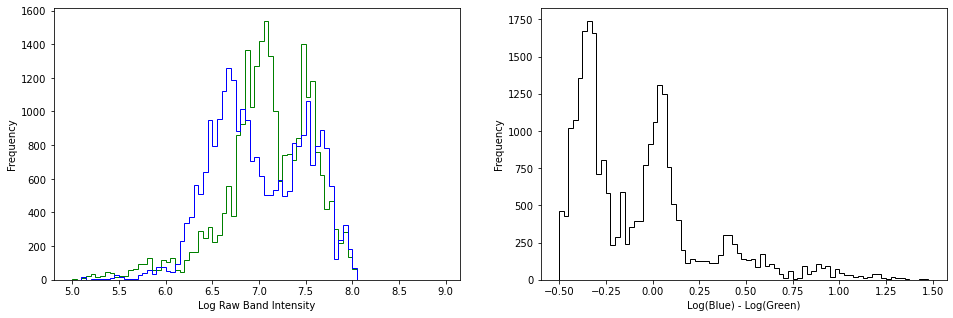

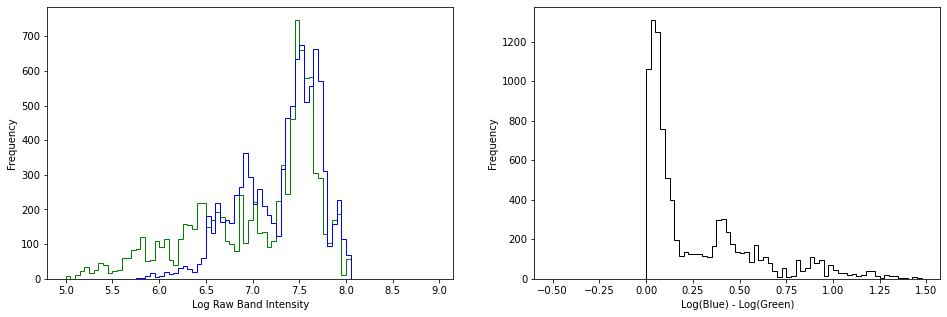

In [33]:
importlib.reload(pt)

### calculates the log difference between band2 and band3 pixels
delta = 0.0001
bp = {'B02': 1, 'B03': 1, 'B04': 1}
safe_file.meta['min_pix'] = bp
train['b2'] = train['b2'].apply(lambda x: max(delta,x - bp['B02'])) #throw out small signal
train['b3'] = train['b3'].apply(lambda x: max(delta,x - bp['B03']))
train['b4'] = train['b4'].apply(lambda x: max(delta,x - bp['B04']))
train['diff_b2_b3'] = train.apply(lambda x: (math.log(x['b2']) - math.log(x['b3'])), axis = 1)
train['diff_b2_b4'] = train.apply(lambda x: (math.log(x['b2']) - math.log(x['b4'])), axis = 1)
train['diff_b3_b4'] = train.apply(lambda x: (math.log(x['b3']) - math.log(x['b4'])), axis = 1)

#clean data ("remove_log_outliers_raw" edits on basis of scatter in individual bands, not on band diff)
train_test = train.copy(deep=True)  #first make a copy of "train" so it can be altered for each S2 image
train_test_cleaned = pt.remove_log_outliers_raw(train_test)

#separate pixels where Blue>Green from Green>Blue (unexpected)
train_test_use = train_test_cleaned.loc[(train_test_cleaned.b3 < train_test_cleaned.b2)]
train_test_toss = train_test_cleaned.loc[(train_test_cleaned.b3 > train_test_cleaned.b2)]

#histogram plots of raw data
reef_plots.depth_histogram_plot(train_test_cleaned)
reef_plots.depth_histogram_plot(train_test_use)

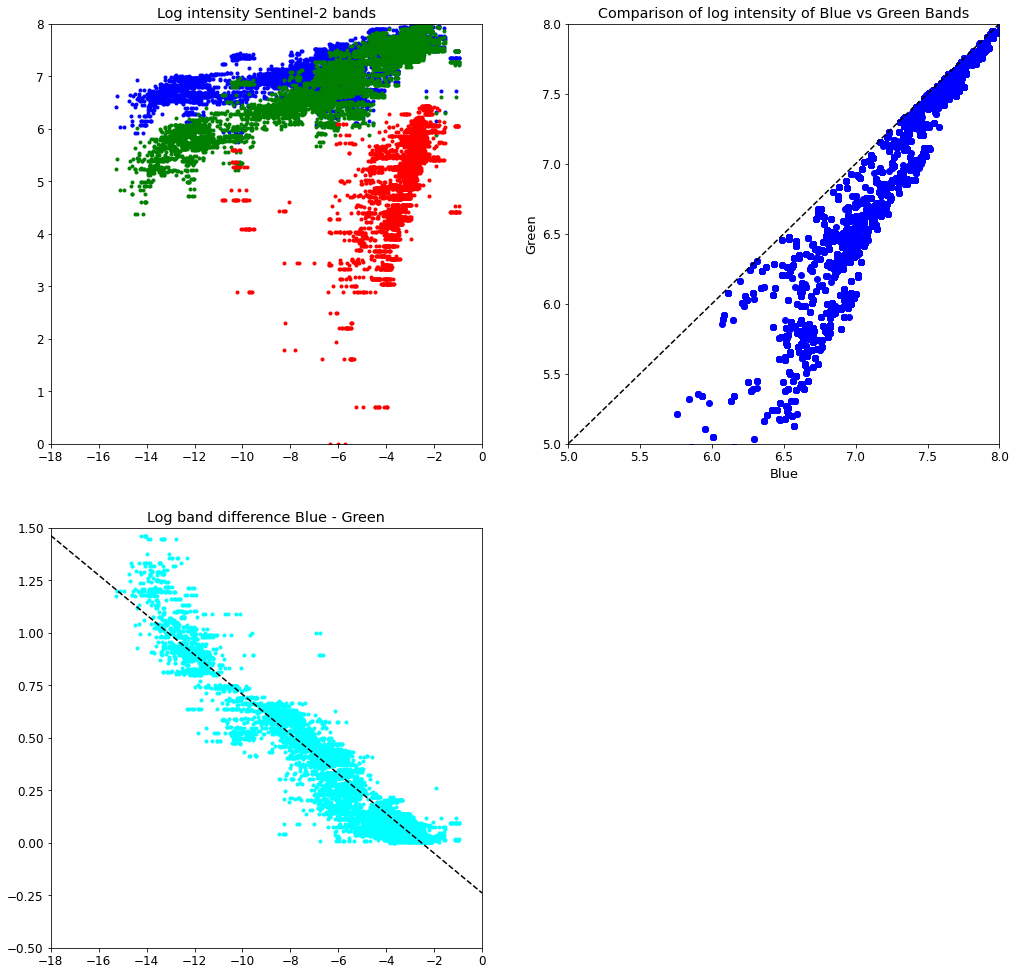

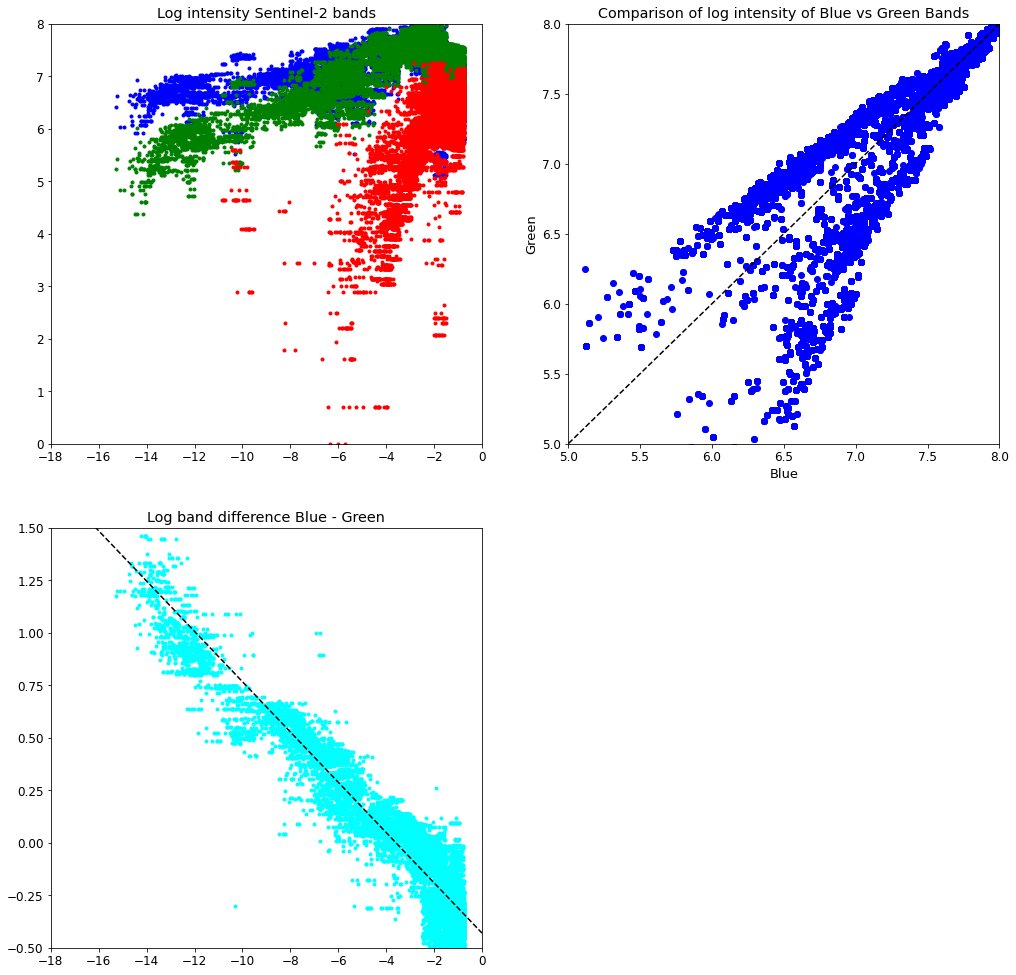

In [34]:
importlib.reload(reef_plots)

#find linear relationship between depths and log of bands for points where Blue>Green
x = train_test_use.loc[:,['Height']]
y = train_test_use.loc[:,['diff_b2_b3']]
m, c = np.polyfit(np.ravel(x), np.ravel(y), 1) #m = slope, c=intercept
reef_plots.plot_sentinel_cal(train_test_use, m, c)

#alternative to above that uses all data
x = train_test_cleaned.loc[:,['Height']]
y = train_test_cleaned.loc[:,['diff_b2_b3']]
m, c = np.polyfit(np.ravel(x), np.ravel(y), 1) #m = slope, c=intercept
reef_plots.plot_sentinel_cal(train_test_cleaned, m, c)

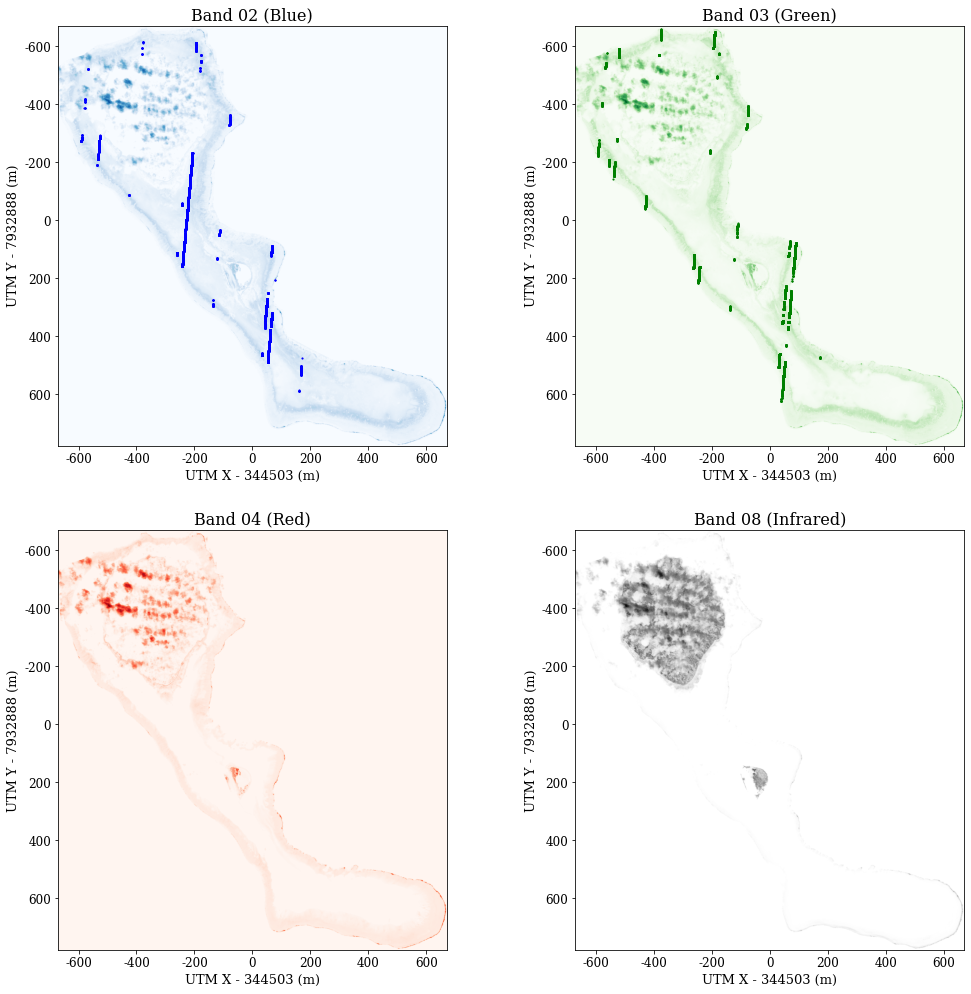

In [35]:
reef_plots.plot_sentinel_bands(imgs, meta, train_test_use, train_test_toss)

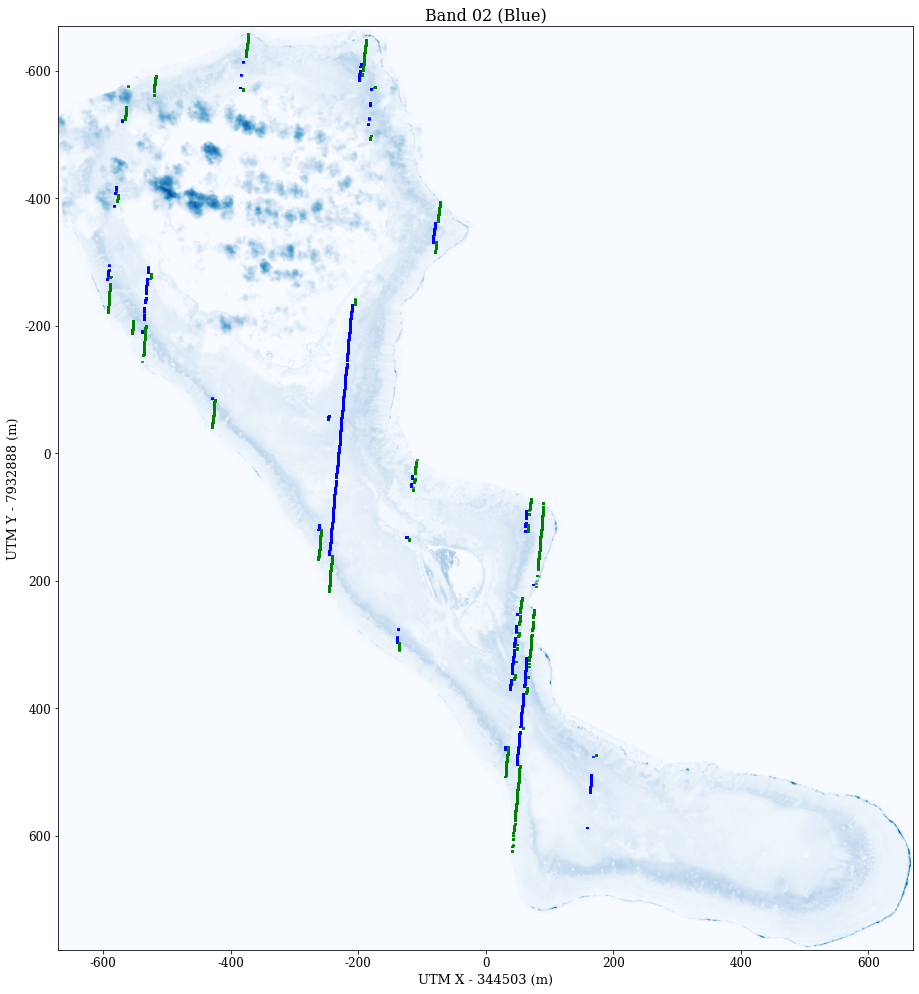

In [36]:
reef_plots.plot_sentinel_bands_closeup(imgs, meta, train_test_use, train_test_toss)

In [37]:
#r = line
#m = metadata
#d = cleaned dataset

sample_median = np.median(train_data_cleaned['diff'])
sample_variance = np.var(train_data_cleaned['diff'])
medians.append(sample_median)
variances.append(sample_variance)

if np.abs(sample_median) < median_threshold and sample_variance < variance_threshold:


SyntaxError: unexpected EOF while parsing (<ipython-input-37-8b8a971dc1db>, line 10)

## Testing: Get tides

In [38]:
epoch = datetime.utcfromtimestamp(0)
dt = is2.get_date()
ut = (dt - epoch).total_seconds()
print(epoch)
print(dt)
print(dt - epoch)
print(ut)

bbox = is2.bbox_coordinates
print(bbox)

1970-01-01 00:00:00
2020-03-08 14:56:11
18329 days, 14:56:11
1583679371.0
(-178.53760600090027, -18.755206591925898, -178.4115636348724, -18.62375715561433)


In [39]:
#tide_level = tide.get_tide(is2.bbox_coordinates, is2.get_date())
min_longitude,min_latitude,max_longitude,max_latitude = is2.bbox_coordinates
lat = str((min_latitude+max_latitude)/2)
lon = str((min_longitude+max_longitude)/2)
stadist = 100
base_url = 'https://www.worldtides.info/api/v2?heights'

tide_datum = 'MTL'
query_string = '&lat={lat}&lon={lon}&start={ut}&datum={datum}&key={api_key}&station_distance={stadist}'\
    .format(lat = lat,lon = lon,ut = ut,datum = tide_datum,api_key = tide.get_API_key(),stadist=stadist)
print(query_string)

&lat=-18.689481873770113&lon=-178.47458481788635&start=1583679371.0&datum=MTL&key=fee8ff39-48eb-42a7-bcc5-3819fce3c1e4&station_distance=100


In [40]:
url = base_url + query_string
#hitting API and storing contents in json format
r = requests.get(url)
tide = json.loads(r.text)

In [41]:
print(tide['heights'][0:1])
print(tide['responseLat'])
print(tide['responseLon'])
print(tide['atlas'])
print(tide['responseLat'])
print(tide['responseLon'])
print(tide['responseDatum'])

[{'dt': 1583679371, 'date': '2020-03-08T14:56+0000', 'height': 0.003}]
-18.6667
-178.5
TPXO
-18.6667
-178.5
MTL
